#**HBOS and ECOD**

**Objective:** The objective is to apply outlier detection techniques, specifically HBOS and ECOD, to identify unusual data points in a dataset. By comparing and analyzing the results from these algorithms, we aim to assess their effectiveness in detecting outliers and gain insights into exceptional data patterns for potential business implications.

## Setting up Environment

* Importing libraries

In [ ]:
#!pip install pyod
#!pip install combo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import tabulate
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
warnings.filterwarnings('ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
from pyod.utils.utility import standardizer
from pyod.models.hbos import HBOS
from pyod.models.combination import aom, moa, average, maximization
from pyod.models.ecod import ECOD


* Creating theme for graphs

In [ ]:
# Create a custom style based on WSJ
wsj_style = {
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelsize': 14,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 8,
    'axes.grid': True,
    'axes.grid.axis': 'y',
    'grid.color': 'gray',
    'grid.linestyle': '--'
}

# Apply the custom style
style.use(wsj_style)

## About Dataset

In [ ]:
df = pd.read_csv('credit_features.csv')
df = df.dropna()
# Remove rows with infinite or extremely large values
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
# Reset the index of the DataFrame after removing rows
df.reset_index(drop=True, inplace=True)
df.head(5)

,Monthly_Total_Spending,avg_transaction_amount_per_vendor,vendor_txn_count,vendor_txn_std,amtPerc_MCC,pct_monthly_spend,amtChangePrevMonth,pct_avg_monthly_spend,pct_avg_vendor_spend,pct_avg_MCC_spend,vendor_txn_cv,MCC_txn_cv,vendor_spend_change,MCC_spend_change,total_spend_change
0,11459780.65,737.142857,7,198.554299,0.882911,0.000076,0.000000,0.000083,1.207364,2.028983,0.249376,2.061742,0.0,0.0,0.000000
1,11459780.65,183.815818,55,295.164021,0.583893,0.000031,-0.585438,0.000035,2.007227,0.853859,1.591095,3.057234,0.0,0.0,-0.585438
2,11459780.65,88.541000,20,116.611287,0.432509,0.000014,0.000000,0.000016,1.872805,0.238812,1.283684,2.496029,0.0,0.0,0.000000
3,11459780.65,63.687340,1673,87.806562,0.791428,0.000008,-0.418707,0.000009,1.513488,1.314954,1.378301,1.835614,0.0,0.0,-0.418707
4,11459780.65,149.086973,641,227.925244,0.632642,0.000011,0.000000,0.000012,0.844876,0.571585,1.527614,2.424079,0.0,0.0,0.000000


## EDA of the New Features

### Existing Features
1. Total Monthly Spending
2. Average Transaction Amount per Vendor
3. Transaction Frequency per Vendor
4. Transaction Amount Variability per Vendor
5. Transaction Amount Percentile within Merchant Category Code (MCC)
6. Transaction Amount as a Percentage of Monthly Spending
7. Transaction Amount vs. Previous Month

### New Features Created
1. **Transaction Amount as a Percentage of Average Monthly Spending**: Helps detect transactions significantly above or below a cardholder's typical monthly spending.

2. **Transaction Amount as a Percentage of Average Vendor Spending**: Identifies transactions deviating from a cardholder's typical spending pattern with a specific vendor.

3. **Transaction Amount as a Percentage of Average MCC Spending**: Detects transactions that deviate from the average spending within the same Merchant Category Code.

4. **Transaction Amount Variability Relative to Vendor**:Flags transactions with unusually high variation in spending with a particular vendor.

5. **Transaction Amount Variability Relative to MCC**: Identifies transactions with unusually high variation within a specific Merchant Category Code.

6. **Transaction Amount Change Relative to Previous Month's Vendor Spending**: Helps spot significant changes in spending with a specific vendor compared to the previous month.

7. **Transaction Amount Change Relative to Previous Month's MCC Spending**: Detects significant changes in spending within the same Merchant Category Code compared to the previous month.

8. **Transaction Amount Change Relative to Previous Month's Total Spending** Flags significant changes in total monthly spending compared to the previous month, which may indicate anomalies in overall spending patterns.

In [ ]:
df.describe()

,Monthly_Total_Spending,avg_transaction_amount_per_vendor,vendor_txn_count,vendor_txn_std,amtPerc_MCC,pct_monthly_spend,amtChangePrevMonth,pct_avg_monthly_spend,pct_avg_vendor_spend,pct_avg_MCC_spend,vendor_txn_cv,MCC_txn_cv,vendor_spend_change,MCC_spend_change,total_spend_change
count,1.704590e+05,170459.000000,170459.000000,170459.000000,170459.000000,170459.000000,170459.000000,170459.000000,170459.000000,170459.000000,170459.000000,170459.000000,170459.000000,170459.000000,170459.000000
mean,1.055483e+07,373.510362,1112.973894,656.944928,0.498464,0.000035,7.226553,0.000036,1.000000,0.985466,1.676390,3.107749,5.529844,6.092889,7.226553
std,1.729036e+06,767.293537,2153.334735,1285.797807,0.287646,0.000154,1147.077664,0.000157,2.854439,3.407981,2.310308,1.411734,1170.097293,1177.607837,1147.077664
min,-4.182000e+01,-3047.263333,2.000000,0.000000,0.000088,-0.002879,-78238.000000,-0.002962,-331.455088,-60.780416,-98.853403,-2.403359,-26496.000000,-48965.000000,-78238.000000
25%,9.277094e+06,95.878990,15.000000,124.522830,0.252885,0.000003,-0.767191,0.000003,0.231907,0.125405,0.901747,2.128927,-0.328138,-0.525216,-0.767191
50%,1.105148e+07,194.641260,108.000000,298.773514,0.497300,0.000009,-0.022126,0.000010,0.618393,0.364751,1.490234,3.048288,0.000000,0.000000,-0.022126
75%,1.145978e+07,429.749311,656.000000,692.065803,0.745945,0.000028,1.784662,0.000029,1.174394,0.907566,2.177576,3.576178,0.153717,0.572429,1.784662
max,1.264678e+07,58958.940000,7493.000000,36150.834188,1.000000,0.020372,451251.000000,0.021068,463.642857,436.981765,216.368961,13.076651,451251.000000,451251.000000,451251.000000


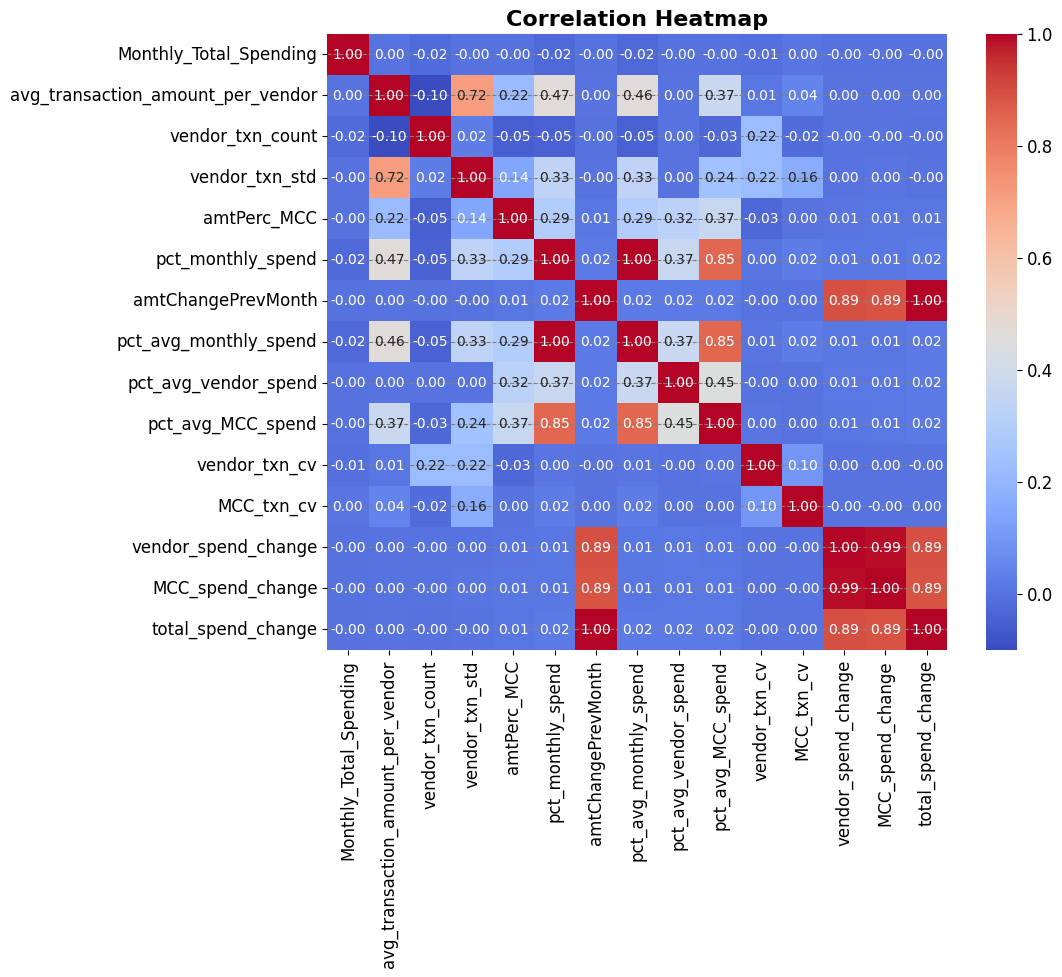

In [ ]:
# Correlation matrix
correlation_matrix = df.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

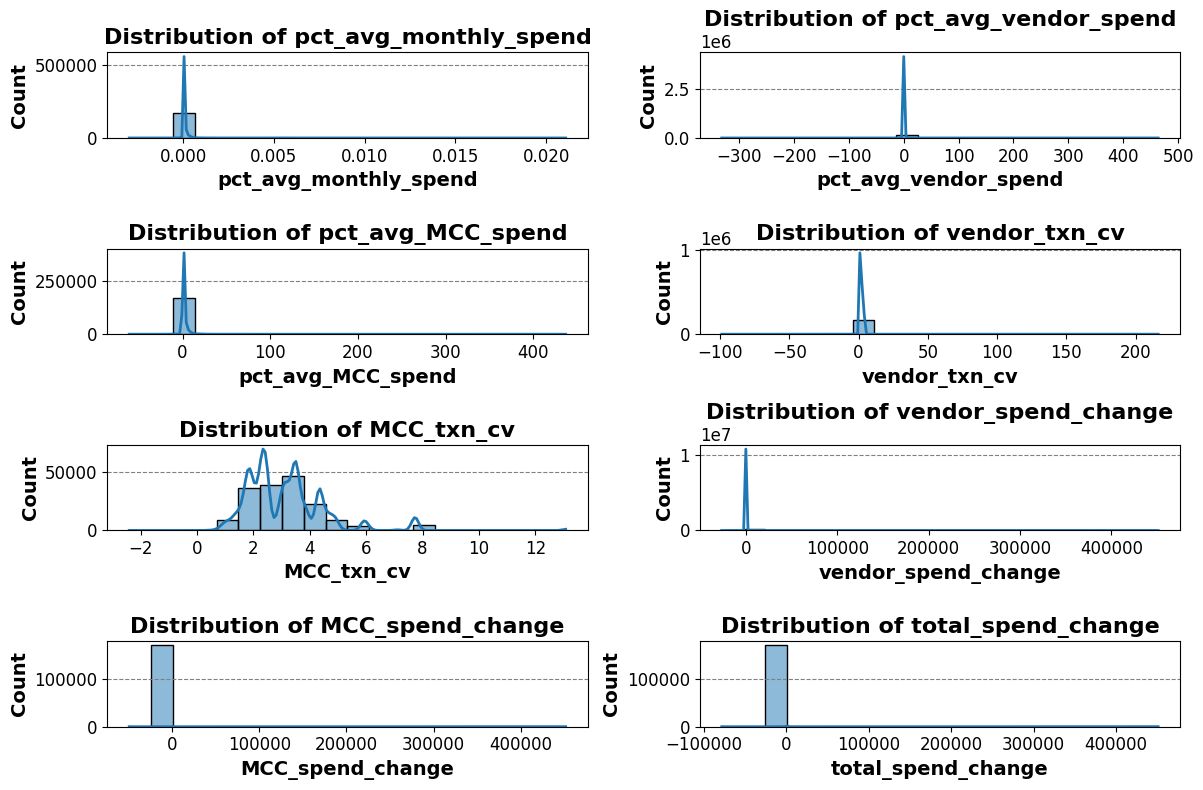

In [ ]:
#EDA of the new features
features = ['pct_avg_monthly_spend', 'pct_avg_vendor_spend', 'pct_avg_MCC_spend',
            'vendor_txn_cv', 'MCC_txn_cv', 'vendor_spend_change', 'MCC_spend_change', 'total_spend_change']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[feature], kde=True, bins=20)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)


plt.tight_layout()
plt.show()

## Splitting data

In [ ]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=123)

# Print the shapes of the resulting data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (136367, 15)
X_test shape: (34092, 15)


## Histogram-based Outlier Score (HBOS)


###  **Building Model**

In [ ]:
n_bins = 50
hbos = HBOS(n_bins=n_bins,contamination=0.05)
hbos.fit(X_train)

# Training data
y_train_scores = hbos.decision_function(X_train)
y_train_pred = hbos.predict(X_train)

# Test data
y_test_scores = hbos.decision_function(X_test)
y_test_pred = hbos.predict(X_test) # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , hbos.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))

The threshold for the defined comtanimation rate: 14.56301634467921
The training data: {0: 129548, 1: 6819}
The training data: {0: 32355, 1: 1737}


### **Determining a reasonable threshold**

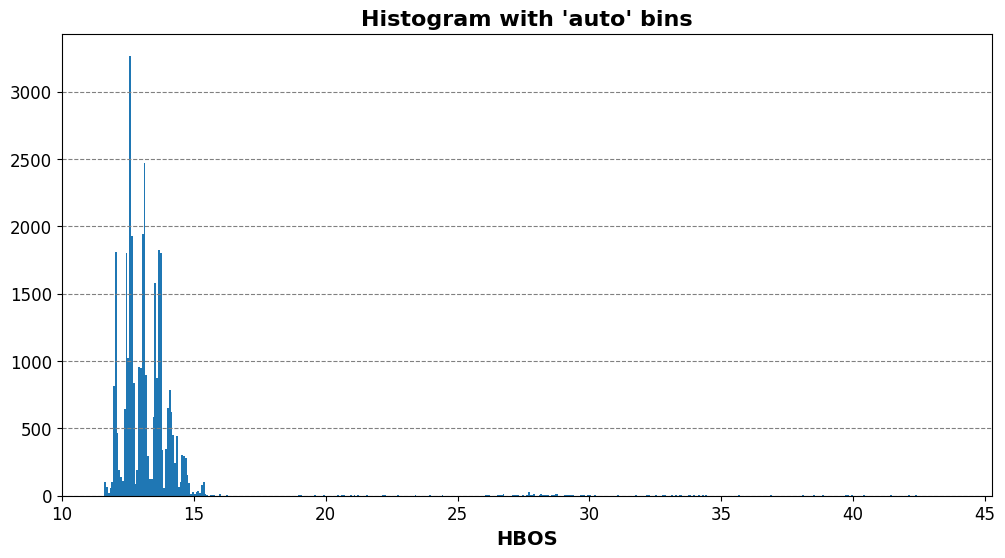

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(y_test_scores, bins='auto')
plt.title("Histogram with 'auto' bins")
plt.xlabel('HBOS')
plt.show()

In the histogram generated using the decision_function of HBOS algorithm, it becomes evident that the threshold or cut point, which distinguishes outliers from inliers, falls within the range of values roughly spanning from 16 to 19.

### **Presenting the summary statistics of the normal and the abnormal groups**

In [ ]:
threshold = hbos.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

In [ ]:
descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,Monthly_Total_Spending,avg_transaction_amount_per_vendor,vendor_txn_count,vendor_txn_std,amtPerc_MCC,pct_monthly_spend,amtChangePrevMonth,pct_avg_monthly_spend,pct_avg_vendor_spend,pct_avg_MCC_spend,vendor_txn_cv,MCC_txn_cv,vendor_spend_change,MCC_spend_change,total_spend_change,Anomaly_Score
0,Normal,129548,94.999523,10556334.75,344.96,1157.08,602.71,0.49,0.0,3.61,0.0,0.9,0.78,1.62,3.04,3.05,3.07,3.61,13.05
1,Outlier,6819,5.000477,10483557.17,903.08,314.47,1667.50,0.66,0.0,88.25,0.0,2.8,4.88,2.58,4.43,72.07,76.39,88.25,18.54


In [ ]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,Monthly_Total_Spending,avg_transaction_amount_per_vendor,vendor_txn_count,vendor_txn_std,amtPerc_MCC,pct_monthly_spend,amtChangePrevMonth,pct_avg_monthly_spend,pct_avg_vendor_spend,pct_avg_MCC_spend,vendor_txn_cv,MCC_txn_cv,vendor_spend_change,MCC_spend_change,total_spend_change,Anomaly_Score
0,Normal,32355,94.904963,10564575.57,346.62,1147.50,607.81,0.49,0.0,3.93,0.0,0.92,0.79,1.65,3.04,1.49,2.06,3.93,13.06
1,Outlier,1737,5.095037,10541352.16,924.62,314.76,1649.63,0.67,0.0,20.67,0.0,2.57,4.69,2.65,4.50,4.34,30.90,20.67,18.49


**pct_monthly_spend** and **pct_avg_monthly_spend** both are 0.0 in Normal and Outliers group. These variables that will not be discriminatory, then we do not need to use them. Let's look at the summary statistics after removing those two variables

In [ ]:
def descriptive_stat_threshold(df, pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score': 'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100  # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index()  # The avg.

    # Drop the columns you want to remove
    stat = stat.drop(['pct_monthly_spend', 'pct_avg_monthly_spend'], axis=1)

    stat = cnt.merge(stat, left_on='Group', right_on='Group')  # Put the count and the avg. together
    return stat

In [ ]:
descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,Monthly_Total_Spending,avg_transaction_amount_per_vendor,vendor_txn_count,vendor_txn_std,amtPerc_MCC,amtChangePrevMonth,pct_avg_vendor_spend,pct_avg_MCC_spend,vendor_txn_cv,MCC_txn_cv,vendor_spend_change,MCC_spend_change,total_spend_change,Anomaly_Score
0,Normal,129548,94.999523,10556334.75,344.96,1157.08,602.71,0.49,3.61,0.9,0.78,1.62,3.04,3.05,3.07,3.61,13.05
1,Outlier,6819,5.000477,10483557.17,903.08,314.47,1667.50,0.66,88.25,2.8,4.88,2.58,4.43,72.07,76.39,88.25,18.54


In [ ]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,Monthly_Total_Spending,avg_transaction_amount_per_vendor,vendor_txn_count,vendor_txn_std,amtPerc_MCC,amtChangePrevMonth,pct_avg_vendor_spend,pct_avg_MCC_spend,vendor_txn_cv,MCC_txn_cv,vendor_spend_change,MCC_spend_change,total_spend_change,Anomaly_Score
0,Normal,32355,94.904963,10564575.57,346.62,1147.50,607.81,0.49,3.93,0.92,0.79,1.65,3.04,1.49,2.06,3.93,13.06
1,Outlier,1737,5.095037,10541352.16,924.62,314.76,1649.63,0.67,20.67,2.57,4.69,2.65,4.50,4.34,30.90,20.67,18.49


### **Achieving Model Stability by Aggregating Multiple Models**

In [ ]:
# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Test a range of binning
k_list = [5, 10, 15, 20, 25, 30, 50, 60, 75, 100]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]
    hbos = HBOS(n_bins=k)
    hbos.fit(X_train_norm)
    # Store the results in each column:
    train_scores[:, i] = hbos.decision_function(X_train_norm)
    test_scores[:, i] = hbos.decision_function(X_test_norm)
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

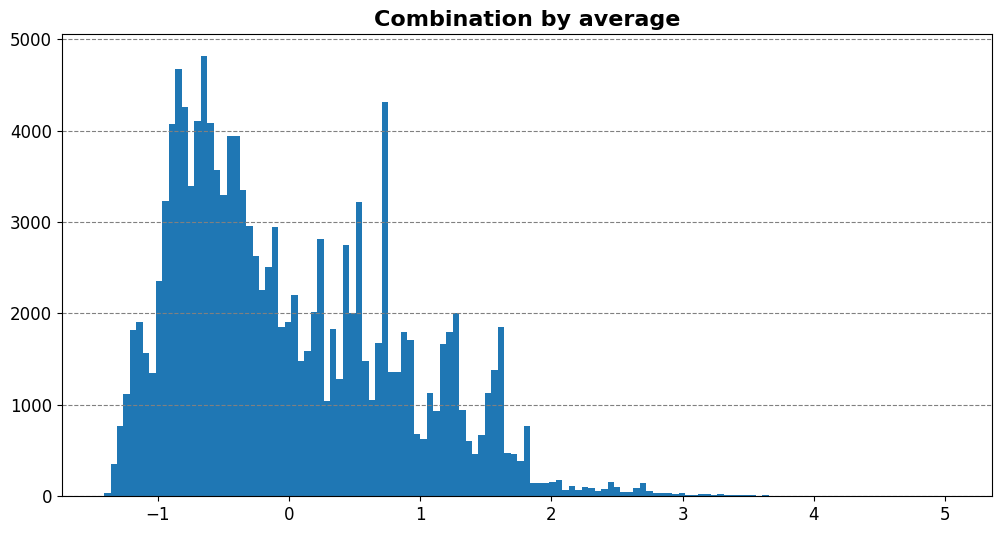

In [ ]:
# Combination by average
# The test_scores_norm is 500 x 10. The "average" function will take the average of the 10 columns. The result "y_by_average" is a single column:
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
plt.figure(figsize=(12, 6))
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

The histogram  suggests a threshold of 3.7. The descriptive statistics with this threshold are shown in the table above. It identifies 63 data points to be the outliers.

* **Summary statistics for the variables**

In [ ]:
descriptive_stat_threshold(X_train,y_train_by_average, 3.7)

,Group,Count,Count %,Monthly_Total_Spending,avg_transaction_amount_per_vendor,vendor_txn_count,vendor_txn_std,amtPerc_MCC,amtChangePrevMonth,pct_avg_vendor_spend,pct_avg_MCC_spend,vendor_txn_cv,MCC_txn_cv,vendor_spend_change,MCC_spend_change,total_spend_change,Anomaly_Score
0,Normal,136304,99.953801,10553707.60,371.53,1114.88,652.06,0.50,7.95,0.99,0.96,1.67,3.10,6.48,6.70,7.95,-0.0
1,Outlier,63,0.046199,8363018.14,3280.04,1257.75,9097.71,0.97,-232.07,23.60,57.52,4.21,5.28,62.79,70.27,-232.07,4.1


## Empirical Cumulative Distribution-based Outlier Detection (ECOD)

### **Building Model**

In [ ]:
ecod = ECOD(contamination=0.05)
ecod.fit(X_train)

# Training data
y_train_scores = ecod.decision_function(X_train)
y_train_pred = ecod.predict(X_train)

# Test data
y_test_scores = ecod.decision_function(X_test)
y_test_pred = ecod.predict(X_test) # outlier labels (0 or 1)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , ecod.threshold_)

The training data: {0: 129548, 1: 6819}
The training data: {0: 32390, 1: 1702}
The threshold for the defined comtanimation rate: 38.96720546845036


### **Determining a reasonable threshold**

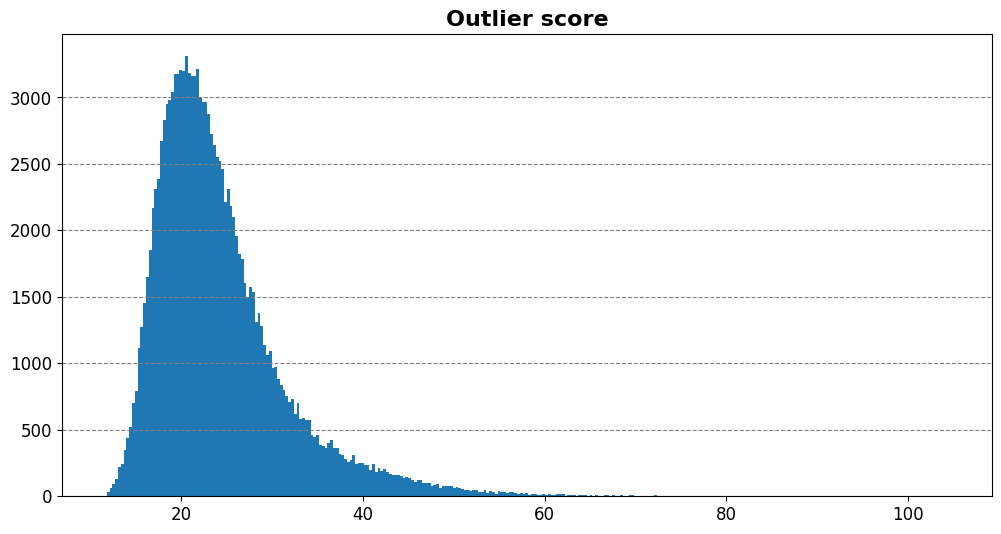

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(y_train_scores, bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

### **Presenting the descriptive statistics of the normal and the abnormal groups**

In [ ]:
threshold = ecod.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,Monthly_Total_Spending,avg_transaction_amount_per_vendor,vendor_txn_count,vendor_txn_std,amtPerc_MCC,pct_monthly_spend,amtChangePrevMonth,pct_avg_monthly_spend,pct_avg_vendor_spend,pct_avg_MCC_spend,vendor_txn_cv,MCC_txn_cv,vendor_spend_change,MCC_spend_change,total_spend_change,Anomaly_Score
0,Normal,129548,94.999523,10559897.72,337.89,1121.21,602.44,0.5,0.0,3.13,0.0,0.92,0.76,1.63,3.09,1.00,1.3,3.13,23.19
1,Outlier,6819,5.000477,10415867.53,1037.38,995.98,1672.63,0.5,0.0,97.22,0.0,2.43,5.23,2.41,3.41,111.06,110.0,97.22,46.03


**pct_monthly_spend** and **pct_avg_monthly_spend** both are 0.0 in Normal and Outliers group. These variables that will not be discriminatory, then we do not need to use them. Let's look at the summary statistics after removing those two variables

In [ ]:
threshold = ecod.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.

    # Drop the columns you want to remove
    stat = stat.drop(['pct_monthly_spend', 'pct_avg_monthly_spend'], axis=1)

    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)


* **Summary statistics for the variables**

In [ ]:
descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,Monthly_Total_Spending,avg_transaction_amount_per_vendor,vendor_txn_count,vendor_txn_std,amtPerc_MCC,amtChangePrevMonth,pct_avg_vendor_spend,pct_avg_MCC_spend,vendor_txn_cv,MCC_txn_cv,vendor_spend_change,MCC_spend_change,total_spend_change,Anomaly_Score
0,Normal,129548,94.999523,10559897.72,337.89,1121.21,602.44,0.5,3.13,0.92,0.76,1.63,3.09,1.00,1.3,3.13,23.19
1,Outlier,6819,5.000477,10415867.53,1037.38,995.98,1672.63,0.5,97.22,2.43,5.23,2.41,3.41,111.06,110.0,97.22,46.03


## Comparing the two models

In [ ]:
#HBOS
n_bins = 50
hbos = HBOS(n_bins=n_bins, contamination=0.05)
hbos.fit(X_train)
y_train_hbos_pred = hbos.labels_
y_test_hbos_pred = hbos.predict(X_test)
y_train_hbos_scores = hbos.decision_function(X_train)
y_test_hbos_scores = hbos.decision_function(X_test)

#ECOD
clf_name = 'ECOD'
ecod = ECOD(contamination=0.05)
ecod.fit(X_train)
y_train_ecod_pred = ecod.labels_
y_test_ecod_pred = ecod.predict(X_test)
y_train_ecod_scores = ecod.decision_scores_  # raw outlier scores
y_test_ecod_scores = ecod.decision_function(X_test)

# Thresholds
[ecod.threshold_, hbos.threshold_]

[38.96720546845036, 14.56301634467921]

In [ ]:
Actual_pred = pd.DataFrame({ 'HBOS_pred': y_test_hbos_pred, 'ECOD_pred': y_test_ecod_pred})
Actual_pred.head()
pd.crosstab(Actual_pred['HBOS_pred'],Actual_pred['ECOD_pred'])

ECOD_pred,0,1
HBOS_pred,,
0,31190,1165
1,1200,537


## Analysis

### HBOS

**What is the method?**

HBOS (Histogram-based Outlier Score) is a method for detecting outliers in data. It constructs histograms for each of the N variables, where the height of a bin represents the "outlier-ness." Higher bin heights correspond to common observations, while lower heights indicate outliers. The univariate outlier score is calculated as the inverse of the bin height, and it can be applied to both categorical and numeric variables by discretizing numeric data into equal-width bins. The sum of these univariate scores results in the HBOS, with the maximum height of each histogram normalized to 1.0.

**What is the model?**
    
In this context, we are harnessing the features generated in assignment 2 to enhance our credit risk fraud detection efforts. The dataset encompasses 15 distinct features, each of which plays a crucial role in this analysis. To aid in the detection of fraud, we're incorporating the Histogram-based Outlier Score (HBOS) method with a contamination rate set to 0.05.

It's important to highlight that this is an unsupervised learning approach, which means we lack a designated target variable (y) for guidance. Instead, the dataset has been split into two subsets, specifically X_train, which constitutes 80% of the data, and X_test, comprising the remaining 20%. These subsets are instrumental in training and evaluating our model. The absence of a y variable underscores the challenge of fraud detection, as it relies solely on identifying patterns and anomalies within the feature set, a task that HBOS will assist us in achieving.

**Have you tested a range of values for the hyper-parameters of the method, and could you please share the results of this testing?**

In the context of Hyperparameter Optimization for HBOS algorithm, the choice of the **number of bins is crucial**. The number of bins affects the sensitivity of HBOS in identifying outliers. If the bins are too narrow, normal data may be incorrectly labeled as outliers, while if they are too wide, outliers may go unnoticed among normal data.

To ensure a stable model outcome, I have created multiple HBOS models with a range of histogram widths, specifically using 10 different bin values, such as [5, 10, 15, 20, 35, 30, 50, 60, 75, 100]. The final model prediction is obtained by averaging the scores from these models.

**Where are the outliers?**

Outliers are identified based on the "Anomaly_Score," with a threshold set at 14.5 for the HBOS method. All data points in the "Outlier" group with "Anomaly_Score" values above 14.5 are considered outliers. In this case, it appears that the only detected outliers are in the "Outlier" group.

**What is the business insight? Interpret the outliers found in the analysis**

The business insight from this analysis is that these outliers exhibit characteristics such as significantly higher average transaction amounts per vendor, much higher vendor transaction standard deviation, and substantial changes in spending patterns compared to the "Normal" group. The "Anomaly_Score" for these outliers is substantially below the threshold, indicating they are distinct anomalies.

The presence of these outliers suggests potential irregularities or unusual spending behavior in the "Outlier" group, which could be of interest to the business for further investigation. It could indicate instances of exceptionally high spending or other unique patterns that may warrant closer examination to understand the underlying reasons and potentially take appropriate actions.

### ECOD

**What is the method?**

ECOD (Empirical Copula-based Outlier Detection) begins by estimating the distribution of a variable without using parametric models. It then calculates an anomaly score for an observation by multiplying the estimated tail probabilities of all dimensions. To simplify the estimation process, ECOD assumes that the variables are independent, allowing it to estimate the empirical cumulative distribution of each variable. This assumption of variable independence is not new, as a similar approach is used by HBOS.

**What are your models?**

In this context, we are using the ECOD (Empirical Copula-based Outlier Detection) method to aid in the detection of credit risk fraud. This method is applied to a dataset that includes 15 distinct features, each of which is crucial in our analysis. The contamination rate for this task is set at 0.05.

It's important to highlight that our approach is unsupervised, which means we lack a designated target variable (y) for guidance in identifying fraud. Instead, we have divided the dataset into two subsets, X_train (constituting 80% of the data) and X_test (comprising the remaining 20%). These subsets serve as the basis for training and evaluating our model. The absence of a y variable underscores the challenge of fraud detection, as it relies solely on patterns and anomalies within the feature set, making ECOD a valuable tool in this context.

**Have you tested a range of values for the hyper-parameters of the method, and could you please share the results of this testing?**

ECOD has no hyper-parameters to tune, it is fast for handling a large amount of data.

**Where are the outliers?**

The outliers are determined using Empirical Cumulative Distribution-based Outlier Detection (ECOD) with a threshold of 38.96. The "Anomaly_Score" for this outlier is 46.03, which significantly exceeds the specified threshold, indicating that this particular data point stands out as an outlier.

**What is the business insight? Interpret the outliers found in the analysis**

From a business perspective, this outlier could represent an unusual spending pattern, possibly from a high-value or corporate client or a one-time anomaly, such as a bulk purchase or a significant change in transaction behavior. Detecting and analyzing such outliers is vital for understanding exceptional events, potential fraud, or identifying valuable customers or clients. It's crucial to investigate further, as these outliers may provide insights into business strategies, fraud detection, or customer segmentation for targeted marketing or service improvements.